# Demo Script for Milestone 10.15

## 0 Prepare task

### 0.1 prepare planning scene

#### Run camera server on the camera computer (192.168.0.10, use vnc viewer)
```bash
python stream_server.py --ip='192.168.0.10'
```
#### Run shared detector on bash
```bash
python3 /home/jhkim/Projects/rnb-planning/src/scripts/milestone_202110/utils/shared_detector.py
```

### Check IP request ip setting from mobile udp client (robot-side)

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src/scripts/milestone_202110'))

from pkg.global_config import RNB_PLANNING_DIR
from demo_utils.kiro_udp_send import start_mobile_udp_thread, send_pose_wait, get_xyzw_cur, get_reach_state
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from pkg.project_config import *
from demo_utils.streaming import *
from demo_utils.detect_table import *
from demo_utils.area_select import *
from pkg.detector.aruco.marker_config import get_aruco_map
aruco_map = get_aruco_map()


CONNECT_CAM = False # True
ENABLE_DETECT = False
# DETECT_MARKER = True
CONNECT_INDY = False # True
CONNECT_MOBILE = False # True 
VISUALIZE = True

# Tool dimensions
TOOL_DIM = [0.32, 0.08]
TOOL_OFFSET = 0.01
MARGIN = 0
TRACK_THICKNESS = 0.001

INDY_BASE_OFFSET = (0.172,0,0.439)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001

ip_cur = "192.168.0.8"# get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"
CAM_HOST = '192.168.0.10'

print("Current PC IP: {}".format(ip_cur))
print("Mobile ROB IP: {}".format(MOBILE_IP))
print("CAM SERVER IP: {}".format(CAM_HOST))

from pkg.geometry.builder.scene_builder import SceneBuilder
from demo_utils.environment import *

from utils.streaming import *
from utils.detection_util import *

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                MOBILE_IP)
robot_config = RobotConfig(1, RobotType.indy7, (INDY_BASE_OFFSET, (0,0,0)),
                INDY_IP, root_on="kmb0_platform", 
                           specs={"no_sdk":True})
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[False, CONNECT_INDY])

s_builder = SceneBuilder(None)
gscene = s_builder.create_gscene(crob)

gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
gscene.set_workspace_boundary(-3, 7, -5, 5, -CLEARANCE, 3, thickness=WALL_THICKNESS)


from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=TIP_LINK)
# add_indy_tool_kiro(gscene, tool_link=TIP_LINK, face_name=TOOL_NAME, zoff=TOOL_OFFSET)

HOME_POSE = -crob.home_pose
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

# Set planner
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
mplan = MoveitPlanner(pscene, enable_dual=False, incremental_constraint_motion=True)
mplan.motion_filters = [GraspChecker(pscene)]
mplan.update_gscene()
gcheck = GraspChecker(pscene)
mplan.motion_filters = [gcheck]

from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)

from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

add_kiro_indytool_down(gscene, zoff=TOOL_OFFSET, tool_link=TIP_LINK, face_name=TOOL_NAME)

# Register binders
from pkg.planning.constraint.constraint_actor import VacuumTool, Gripper2Tool, PlacePlane, SweepFramer, WayFramer
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(-gscene.NAME_DICT['brush_face'].dims[0]/2-CLEARANCE,0,0), 
                                  rpy=(0,np.pi/2*1,0))

# waypoint
WP_DIMS = (0.6,0.4,WALL_THICKNESS)
gscene.create_safe(gtype=GEOTYPE.BOX, name="wayframer", link_name=HOLD_LINK,
                   dims=WP_DIMS, center=(0,0,WP_DIMS[2]/2), rpy=(0,0,0), color=(1, 0, 0, 0.5), display=True,
                   collision=False, fixed=True)
wayframer = pscene.create_binder(bname="wayframer", gname="wayframer", _type=WayFramer, 
                                 point=(0,0,-WP_DIMS[2]/2-CLEARANCE), rpy=(0,0,0))

indy = crob.robot_dict["indy1"]

if CONNECT_MOBILE:
    sock_mobile, server_thread = start_mobile_udp_thread(recv_ip=ip_cur)
    time.sleep(1)

Current PC IP: 192.168.0.8
Mobile ROB IP: 192.168.0.102
CAM SERVER IP: 192.168.0.10
connection command:
kmb0: False
indy1: False
Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


### 0.2 Wait task start queue

## 1. Detect scene

### 1.1 Detect bed

### 1.0 Get environment map

In [2]:
from pkg.utils.ros_utils import Listener
from demo_utils.map_converter import *
import cv2

In [3]:
## GET MAP
# map_listener = Listener(topic_name="/map", topic_type=OccupancyGrid)
# cost_listener = Listener(topic_name="/move_base/global_costmap/costmap", topic_type=OccupancyGrid)
# map_data = map_listener.get_data()
# cost_data = cost_listener.get_data()
map_data = load_pickle(os.path.join(os.environ["RNB_PLANNING_DIR"],"data/map_data.pkl"))
cost_data = load_pickle(os.path.join(os.environ["RNB_PLANNING_DIR"],"data/cost_data.pkl"))

In [4]:
## GET LINES
map_im, resolution = convert_map(map_data)
ret, map_bin = cv2.threshold(map_im, 100, 255, cv2.THRESH_BINARY)
lines = cv2.HoughLinesP(map_bin, 1, 1 * np.pi / 180, 30, minLineLength = 10, maxLineGap = 50)
map_shape = map_im.shape
bound_px = int(round(10 * 0.01 / resolution))
line_im_accum = np.zeros(map_shape, np.uint8)
lines_maj = []
idc_exc = set()
line_bounds = np.array([line2im(line[0], map_shape, bound_px) for line in lines])
line_ims = np.array([line2im(line[0], map_shape) for line in lines])
for i_l, (line0, line0bd) in enumerate(zip(lines, line_bounds)):
    if i_l in idc_exc:
        continue
    line_im_accum = np.max([line_im_accum, line0bd], axis=0)
    lines_maj.append(line0)
    idc_inbound = np.where(np.sum(np.sum(line_ims[i_l:] > line_im_accum[np.newaxis, :, :], -1), -1) == 0)[0] + i_l
    idc_exc = idc_exc.union(list(idc_inbound))

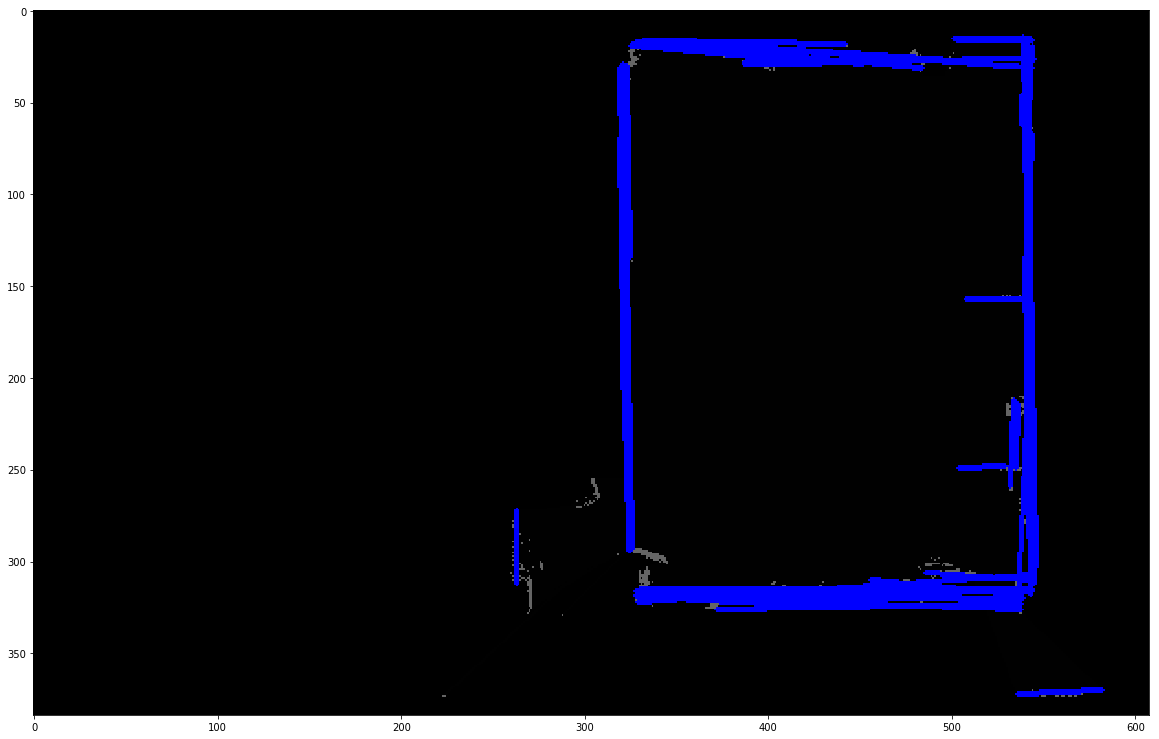

In [5]:
dst = cv2.cvtColor(map_im, cv2.COLOR_GRAY2BGR)
for i in lines_maj:
    cv2.line(dst, (i[0][0], i[0][1]), (i[0][2], i[0][3]), (0, 0, 255), 2)
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
plt.imshow(dst)

In [6]:
T_io_px = T_xyzquat(((lambda x: (x.x+map_shape[0]/2, x.y+map_shape[1]/2, x.z))(map_data.info.origin.position), 
                    (lambda x: (x.x, x.y, x.z, x.w))(map_data.info.origin.orientation)))
T_io = T_io_px.copy()
T_io[:3,3] *= resolution

cur_xyzw = [ 0.8,   1.68, -0.15,  0.99]
Q_CUR = np.copy(crob.home_pose)
Q_CUR[:2] = cur_xyzw[:2]
Q_CUR[2] = Rot2axis(Rotation.from_quat((0,0,cur_xyzw[2], cur_xyzw[3])).as_dcm(), 3)
gscene.show_pose(Q_CUR)
T_om = T_xyzquat(((tuple(cur_xyzw[:2])+(0,)), ((0,0)+tuple(cur_xyzw[2:]))))
T_im = np.matmul(T_io, T_om)

T_bm = wayframer.get_tf_handle(Q_CUR)

T_bi = np.matmul(T_bm, SE3_inv(T_im))

# for i_l, line in enumerate(lines_maj):
#     ptx_px = line[0]
#     pts = np.multiply(ptx_px, resolution)
#     pt1, pt2 = map(lambda pt: np.matmul(T_bi[:2,:2], pt) + T_bi[:2,3], [pts[:2], pts[2:]])
#     add_line_to_gscene(gscene, "map_line_{}".format(i_l), pt1, pt2, 
#                        thickness=bound_px*resolution*2, height=0.2)

#### 1.1.1 Move to bed-seek pose 

In [7]:
VIEW_POSE = np.deg2rad([  0., 50.,  -70.,  -0.,  -90., 0])
VIEW_LOC = [0,]*6
VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(VIEW_POSE_EXT)

* **[TODO] rotate until bed is detected**

In [8]:
if ENABLE_DETECT:
    attacth_to_server()

In [9]:
# CAM_HOST = '192.168.0.40'
if CONNECT_CAM:
    # rdict = send_recv_demo_cam({1:1}, host=CAM_HOST)
    rdict = stream_capture_image(ImageType.FirstView, obj_type="bed", host=CAM_HOST)
    cam_intrins, d_scale = [rdict[key] for key in ["intrins", "depth_scale"]]
    set_cam_params(cam_intrins, d_scale)
    cam_width, cam_height, cam_fx, cam_fy, cam_ppx, cam_ppy = cam_intrins
    __d_scale = d_scale
    bed_color_path = SAVE_DIR + '/bed.jpg'
    bed_depth_path = SAVE_DIR + '/bed.png'
else:
#     cam_intrins = [1280, 720, 899.05322265625,  899.21044921875, 654.8836669921875, 352.9295654296875]
#     d_scale = 0.0002500000118743628
    cam_intrins = [1280, 720, 909.957763671875,  909.90283203125, 638.3824462890625, 380.0085144042969]
    d_scale = 1 / 3999.999810010204
    set_cam_params(cam_intrins, d_scale)
    cam_width, cam_height, cam_fx, cam_fy, cam_ppx, cam_ppy = cam_intrins
    __d_scale = d_scale
    bed_color_path = SAVE_DIR + '/bed.jpg'
    bed_depth_path = SAVE_DIR + '/bed.png'
#     bed_color_path = EXP_IMG_DIR + '/bed.jpg'
#     bed_depth_path = EXP_IMG_DIR + '/bed.png'
#     bed_color_path = EXP_IMG_DIR + '/513.jpg'
#     bed_depth_path = EXP_IMG_DIR + '/top_table_0024.png'

# Read color, depth image file, keep 16bit information
color_img_read = cv2.imread(bed_color_path, flags=cv2.IMREAD_UNCHANGED)
depth_img_read = cv2.imread(bed_depth_path, flags=cv2.IMREAD_UNCHANGED)

# Output of inference(mask for detected table)
mask_out = detect_from_server(color_img_read)

# If bed is not detected, then pass below detection part
test = np.empty((720,1280), dtype=bool)
test[:,:] = False

Detect server not attached - call attach_to_server


In [10]:
while np.array_equal(mask_out, test):
    if CONNECT_INDY:
        with indy:
            Qnow = indy.get_joint_pos()
            Qto = np.add(Qnow, [10,0,0,0,0,0])
            Qto[0] = (Qto[0]+np.pi/2)%np.pi-np.pi/2
            indy.joint_move_to(Qto)
            indy.wait_motion()
    
    
    # Take a picture again after rotate
    time.sleep(1)
    rdict = stream_capture_image(ImageType.FirstView, obj_type="bed", host=CAM_HOST)
    
    # Read color, depth image file, keep 16bit information
    color_img_read = cv2.imread(bed_color_path, flags=cv2.IMREAD_UNCHANGED)
    depth_img_read = cv2.imread(bed_depth_path, flags=cv2.IMREAD_UNCHANGED)
    
    # Output of inference(mask for detected table)
    mask_out = detect_from_server(color_img_read)

#### 1.1.2  detect bed and add to the scene

In [11]:
T_bc = viewpoint.get_tf(VIEW_POSE_EXT)
if ENABLE_DETECT:
    # Try ICP1
    if not np.array_equal(mask_out, test):
        plt.imshow(mask_out)

        # Crop masking part
        vis_mask = (mask_out * 255).astype('uint8')
        color_instance = cv2.bitwise_and(color_img_read, color_img_read, mask=vis_mask).astype(np.uint16)
        depth_instance = cv2.bitwise_and(depth_img_read, depth_img_read, mask=vis_mask).astype(np.uint16)
        cv2.imwrite(CROP_DIR + '/bed_crop.jpg', color_instance)
        cv2.imwrite(CROP_DIR + '/bed_crop.png', depth_instance)

        ICP_result_bed1, fitness1 = process_bed_detection_front(T_bc, visualize=False)

        # Try ICP2
    if not np.array_equal(mask_out, test):
        plt.imshow(mask_out)

        # Crop masking part
        vis_mask = (mask_out * 255).astype('uint8')
        color_instance = cv2.bitwise_and(color_img_read, color_img_read, mask=vis_mask).astype(np.uint16)
        depth_instance = cv2.bitwise_and(depth_img_read, depth_img_read, mask=vis_mask).astype(np.uint16)
        cv2.imwrite(CROP_DIR + '/bed_crop.jpg', color_instance)
        cv2.imwrite(CROP_DIR + '/bed_crop.png', depth_instance)

        ICP_result_bed2, fitness2 = process_bed_detection(visualize=False)
        
    # Better result is adopted
    if fitness1 > fitness2:
        ICP_result_bed = ICP_result_bed1
    else:
        ICP_result_bed = ICP_result_bed2        


    # Coorinate offeset
    T_toff_bed = np.identity(4)
    T_toff_bed[:3,:3] = np.array([[0,1,0],[0,0,1],[1,0,0]])
    T_toff_bed[:3,3] = np.array([0.455,0,1.02])

    T_co_bed = np.matmul(ICP_result_bed, T_toff_bed)
    T_bc = viewpoint.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))
    T_bo_bed = np.matmul(T_bc, T_co_bed)

    bed_center = T_bo_bed[:3,3]
    bed_rpy = Rot2rpy(T_bo_bed[:3,:3])
    # bed_center = (2,0,0)
    # bed_rpy = (0,0,np.pi/2)
    COLOR_BED_COL = (0,1,0,0.3)
    # T_revis = np.identity(4)
    # T_revis[:3,:3] = Rot_axis(3, Rot2axis(bed_vis.get_tf(VIEW_POSE_EXT)[:3,:3],3))
    # bed_rpy = Rot2rpy(Rot_axis(3, Rot2axis(bed_vis.get_tf(VIEW_POSE_EXT)[:3,:3],3)
    T_bo_new = align_z(T_bo_bed)
    bed_rpy = Rot2rpy(T_bo_new[:3,:3])

    # adjust
    bed_center[2]=0
    if Rot_rpy(bed_rpy)[0,0] > 0:
        bed_rpy[2] += np.pi

    bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)
    
else:
    T_bc = viewpoint.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))
    bed_center = (2,0,0)
    bed_rpy = (0,0,np.pi/2)
    COLOR_BED_COL = (0,1,0,0.3)
    bed_mat = add_bed(gscene, bed_center, bed_rpy, COLOR_BED_COL)

bed_vis = gscene.NAME_DICT["bed_vis"]

### 1.2 Detect Closet

#### 1.2.0 set checker

In [12]:
wp_task, wp_hdl = add_waypoint_task(pscene, "waypoint", WP_DIMS, (0,0,0), (0,0,0), 
                                    parent="floor_ws", color=(0, 0, 1, 0.5))
ccheck = CachedCollisionCheck(gcheck, wp_task, wp_hdl, wayframer)

#### 1.2.1  move to full view position

In [13]:
#### 1.2.1.1  decide closet side

In [14]:
bed_vis = gscene.NAME_DICT["bed_vis"]
T_bo = bed_vis.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))

In [15]:
if CONNECT_CAM:
    color_path = SAVE_DIR + '/bed.jpg'
    depth_path = SAVE_DIR + '/bed.png'
else:
    color_path = EXP_IMG_DIR + '/bed.jpg'
    depth_path = EXP_IMG_DIR + '/bed.png'

if ENABLE_DETECT:
    # Determine the location of closet
    CLOSET_LOCATION = check_location_top_table(color_path, depth_path, T_bc, T_bo, bed_dims=bed_mat.dims, 
                                               visualize=False)
    print("CLOSET on {}".format(CLOSET_LOCATION))

#     T_bm_from = wayframer.get_tf_handle(list2dict(VIEW_POSE_EXT, gscene.joint_names))
#     T_bs = bed_mat.get_tf(VIEW_POSE_EXT)

#     if CLOSET_LOCATION == "LEFT":
#         T_sm = SE3(Rot_axis(3, np.pi), [1.5, -1.33, 0])
#     elif CLOSET_LOCATION == "RIGHT":       
#         T_sm = SE3(Rot_axis(3, np.pi), [1.5, 1.33, 0])

#     T_bm = np.matmul(T_bs, T_sm)

#     x,y = T_bm[:2,3]
#     theta = Rot2axis(T_bm[:3,:3], 3)
else:
    CLOSET_LOCATION = "LEFT"
#     T_bs = bed_mat.get_tf(VIEW_POSE_EXT)
#     T_sm = SE3(Rot_axis(3, np.pi), [1.5, -1.33, 0])
#     T_bm = np.matmul(T_bs, T_sm)

#     x,y = T_bm[:2,3]
#     theta = Rot2axis(T_bm[:3,:3], 3)
    
# VIEW_MOVED_EXT = np.add(VIEW_POSE_EXT, [x,y,theta]+[0]*9) 
# gscene.show_pose(VIEW_MOVED_EXT)

#### 1.2.1.2  decide full view position

In [16]:
if CLOSET_LOCATION == "LEFT":
    angle_ref = 150
elif CLOSET_LOCATION == "RIGHT":       
    angle_ref = -150

In [17]:
bed_dim = np.linalg.norm(bed_mat.dims)
h_fov_hf = np.arctan2(cam_intrins[0], 2*cam_intrins[2])
x_z_ratio = np.tan(h_fov_hf)
bed_dist = (bed_dim/2) / x_z_ratio * 3 
while True:
    angle_view = angle_ref + np.random.uniform(-10, 10)
    dist_view = bed_dist + np.random.uniform(-0.5, 1)*bed_dist/4
    Tbs = bed_mat.get_tf(VIEW_POSE_EXT)
    Tbs = np.matmul(Tbs, SE3(np.identity(3), (-bed_mat.dims[0]/2, 0,0)))
    Tsc = np.matmul(SE3(Rot_axis(3, np.deg2rad(angle_view)), (0,)*3), 
                    SE3(np.identity(3), (-dist_view, 0,0)))
    Tbc = np.matmul(Tbs, Tsc)
    Tmc = viewpoint.get_tf(VIEW_POSE_EXT, from_link=MOBILE_BASE)
    Tmc[:3,:3] = np.identity(3)
    Tbm = np.matmul(Tbc, SE3_inv(Tmc))
    full_view_ext = np.copy(VIEW_POSE_EXT)
    full_view_ext[:2] = Tbm[:2,3]
    full_view_ext[2] = Rot2axis(Tbm[:3, :3], 3)
    gscene.show_pose(full_view_ext)
    ccheck.clear()
    res = ccheck(T_loal=Tbm, Q_dict=list2dict(full_view_ext, gscene.joint_names))
    if res:
        VIEW_MOVED_EXT = full_view_ext
        break

#### move to full view position

In [18]:
VIEW_MOVED = np.deg2rad([  0., 50.,  -70.,  -0.,  -80., 0])
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_MOVED))
    
VIEW_MOVED_EXT[crob.idx_dict[ROBOT_NAME]] = VIEW_MOVED

In [19]:
if CONNECT_MOBILE:
    VIEW_MOVED_EXT = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, VIEW_POSE_EXT, VIEW_MOVED_EXT, 
                                              D_APPROACH=0)
gscene.show_pose(VIEW_MOVED_EXT)

#### 1.2.2 redetect bed

In [1]:
#capture image
if CONNECT_CAM:
    rdict = stream_capture_image(ImageType.FullView, obj_type="full_view", host=CAM_HOST)
    

NameError: name 'xx' is not defined

#### 1.2.3  detect and add closet

In [20]:
if ENABLE_DETECT:
    if CONNECT_CAM:
        rdict = stream_capture_image(ImageType.FirstView, obj_type="closet", host=CAM_HOST)
        closet_color_path = SAVE_DIR + '/top_table.jpg'
        closet_depth_path = SAVE_DIR + '/top_table.png'
    else:
        closet_color_path = EXP_IMG_DIR + '/top_table_0024.jpg'
        closet_depth_path = EXP_IMG_DIR + '/top_table_0024.png'

    if CONNECT_CAM:
        Qdict_scan = list2dict(VIEW_MOVED_EXT, gscene.joint_names)
    else:
        VIEW_POSE_MID = np.deg2rad([  0., 50.,  -70.,  -0.,  -75., 180])
        VIEW_MOVED_EXT[6:] = VIEW_POSE_MID
        Qdict_scan = list2dict(VIEW_MOVED_EXT, gscene.joint_names)
    T_bc = viewpoint.get_tf(Qdict_scan)
    T_bs = bed_vis.get_tf(Qdict_scan)
    T_sc = np.matmul(SE3_inv(T_bs), T_bc)

    ICP_result_top_table = process_top_table_detection(closet_color_path, closet_depth_path, T_sc=T_sc,
                                                       bed_dims=bed_mat.dims, z_ceiling = 2.3,
                                                       initial_offset=[0.3,1.1,0.6], floor_margin=0.1,
                                                       visualize=False)

    T_toff_top_table = np.identity(4)
    T_toff_top_table[:3,:3] = np.array([[1,0,0],[0,0,1],[0,-1,0]])
    T_toff_top_table[:3,3] = np.array([0.3,0,0.2725])

    T_co = np.matmul(ICP_result_top_table, T_toff_top_table)
    T_bc = viewpoint.get_tf(list2dict(VIEW_MOVED_EXT, gscene.joint_names))
    T_bo = np.matmul(T_bc, T_co)
    T_bo[:3,:3] = Rot_axis(3, Rot2axis(T_bo[:3,:3], 3))
    T_bo[2,3] = 0
else:
    T_bo = T_xyzrpy((np.matmul(Rot_rpy(bed_rpy), (-0.75,-1.5,0))+bed_center, 
                     bed_rpy))

closet_leftup, closet_rightup, closet_down = add_closet(
    gscene, closet_center=T_bo[:3,3], closet_rpy=Rot2rpy(T_bo[:3,:3]), 
    COLOR_CLOSET_COL=(0,1,0,0.3))


## 2. Closet cleaning

### 2.1. Make closet cleaning plan

In [21]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *
from pkg.utils.code_scraps import get_look_motion

In [22]:
Q_CUR = VIEW_MOVED_EXT
HOME_POSE_SWEEP = np.copy(Q_CUR)
# HOME_POSE_SWEEP[6:] = 0
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    

add_kiro_indytool_down(gscene, zoff=TOOL_OFFSET, tool_link=TIP_LINK, face_name=TOOL_NAME)
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), 
                                  rpy=(0,0,0))

In [23]:
ccheck.clear()
div_base_dict, Tsm_keys, surface_div_centers, div_num, (ax_step, ax_swp, ax_pln) = \
                        get_division_dict(closet_leftup, brush_face, robot_config, 
                                          plane_val=None, tip_dir="up", TOOL_DIM=TOOL_DIM, 
                                          ccheck=ccheck, resolution=0.02)

HOME_POSE_MOVE = np.copy(Q_CUR[6:])
test_fun_cl = TestBaseDivFunc(ppline, floor_ws, closet_leftup, WP_DIMS, TOOL_DIM, crob.home_dict, tool_dir=1,
                              multiprocess=False)
test_fun_cl.clear()

idx_bases, idc_divs, covered_all, snode_schedule_list = select_max_cover_bases(
    div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step, 
    test_fun=test_fun_cl)
snode_schedule_list_leftup, idx_bases, idc_divs, scene_args_list_leftup, scene_kwargs_list_leftup = refine_order_plan(
    ppline, snode_schedule_list, idx_bases, idc_divs, Q_CUR, 
    floor_ws, wayframer, closet_leftup, Tsm_keys, surface_div_centers,  
    WP_DIMS, TOOL_DIM, ROBOT_NAME, MOBILE_NAME, HOME_POSE_MOVE)
test_fun_cl.clear()
Q_CUR = snode_schedule_list_leftup[-1][-1].state.Q

terminate_on_first is deprecated. Use max_solution_count=1
======================= terminated 0: max iteration time reached (1635250092/1635250089.62 s) ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Goal reached
Goal reached
======================= terminated 0: required answers acquired ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Goal reached
Goal reached
======================= terminated 0: required answers acquired ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Goal reached
Goal reached
======================= terminated 0: required answers acquired ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Goal reached
======================= terminated 0: max iteration time reached (1635250098/1635250095.36 s) ===============================
Goal reached
update 1th motion
Goal reached
update 1th motion
Goal reached

In [24]:
ccheck.clear()
div_base_dict, Tsm_keys, surface_div_centers, div_num, (ax_step, ax_swp, ax_pln) = \
                        get_division_dict(closet_rightup, brush_face, robot_config, 
                                          plane_val=None, tip_dir="up", TOOL_DIM=TOOL_DIM, 
                                          ccheck=ccheck, resolution=0.02)

HOME_POSE_MOVE = np.copy(Q_CUR[6:])
test_fun_cl = TestBaseDivFunc(ppline, floor_ws, closet_rightup, WP_DIMS, TOOL_DIM, crob.home_dict, tool_dir=1,
                              multiprocess=False)
test_fun_cl.clear()

idx_bases, idc_divs, covered_all, snode_schedule_list = select_max_cover_bases(
    div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step, 
    test_fun=test_fun_cl)
snode_schedule_list_rightup, idx_bases, idc_divs, scene_args_list_rightup, scene_kwargs_list_rightup = refine_order_plan(
    ppline, snode_schedule_list, idx_bases, idc_divs, Q_CUR, 
    floor_ws, wayframer, closet_rightup, Tsm_keys, surface_div_centers,  
    WP_DIMS, TOOL_DIM, ROBOT_NAME, MOBILE_NAME, HOME_POSE_MOVE)
test_fun_cl.clear()
Q_CUR = snode_schedule_list_rightup[-1][-1].state.Q

terminate_on_first is deprecated. Use max_solution_count=1
Goal reached
Goal reached
======================= terminated 0: required answers acquired ===============================
update 1th motion
Goal reached


In [25]:
ccheck.clear()
div_base_dict, Tsm_keys, surface_div_centers, div_num, (ax_step, ax_swp, ax_pln) = \
                        get_division_dict(closet_down, brush_face, robot_config, 
                                          plane_val=None, tip_dir="down", TOOL_DIM=TOOL_DIM, 
                                          ccheck=ccheck, resolution=0.02)

HOME_POSE_MOVE = np.copy(Q_CUR[6:])
test_fun_cl = TestBaseDivFunc(ppline, floor_ws, closet_down, WP_DIMS, TOOL_DIM, crob.home_dict, tool_dir=-1,
                              multiprocess=False)
test_fun_cl.clear()

idx_bases, idc_divs, covered_all, snode_schedule_list = select_max_cover_bases(
    div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step, 
    test_fun=test_fun_cl)
snode_schedule_list_down, idx_bases, idc_divs, scene_args_list_down, scene_kwargs_list_down = refine_order_plan(
    ppline, snode_schedule_list, idx_bases, idc_divs, Q_CUR, 
    floor_ws, wayframer, closet_down, Tsm_keys, surface_div_centers,  
    WP_DIMS, TOOL_DIM, ROBOT_NAME, MOBILE_NAME, HOME_POSE_MOVE)
test_fun_cl.clear()
Q_CUR = snode_schedule_list_rightup[-1][-1].state.Q

terminate_on_first is deprecated. Use max_solution_count=1
Goal reached
Goal reached
======================= terminated 0: required answers acquired ===============================
terminate_on_first is deprecated. Use max_solution_count=1
======================= terminated 0: max iteration time reached (1635250106/1635250103.57 s) ===============================
terminate_on_first is deprecated. Use max_solution_count=1
======================= terminated 0: max iteration time reached (1635250109/1635250106.67 s) ===============================
terminate_on_first is deprecated. Use max_solution_count=1
======================= terminated 0: max iteration time reached (1635250113/1635250109.93 s) ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Goal reached
Goal reached
======================= terminated 0: required answers acquired ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Goal reached
Goal reache

In [26]:
snode_schedule_list = snode_schedule_list_leftup + snode_schedule_list_rightup + snode_schedule_list_down
scene_args_list = scene_args_list_leftup + scene_args_list_rightup + scene_args_list_down
scene_kwargs_list = scene_kwargs_list_leftup + scene_kwargs_list_rightup + scene_kwargs_list_down

### 2.2. Execute closet cleaning sequence

In [27]:
D_APPROACH = 0.4
UPDATE_MOTION = False
LOOK_ADJUST = True
VEL_LEVEL = 1

if CONNECT_INDY:
    with indy:
        vel_level_bak = indy.get_joint_vel_level()
        print("vel_level_bak: {}".format(vel_level_bak))

    with indy:
        indy.set_joint_vel_level(VEL_LEVEL)

In [28]:
swp_fin_list = []
first_approach = True

for i_s, (snode_schedule, sargs, skwargs) in enumerate(zip(snode_schedule_list, scene_args_list, scene_kwargs_list)):
    print("motions: {}".format(len(snode_schedule[:-1])-1))
    set_base_sweep(*sargs, **skwargs)
    for snode_pre, snode_nxt in zip(snode_schedule[:-1], snode_schedule[1:]):
        snode_pre = snode_pre.copy(pscene)
        snode_pre.traj = None
        from_state = snode_pre.state
        to_state = snode_nxt.state
        subjects, ok = pscene.get_changing_subjects(from_state, to_state)
        print(subjects)

        if len(subjects) ==0 or subjects[0] == "sweep":
            to_state.Q[:6] = from_state.Q[:6]
            if CONNECT_INDY:
                if UPDATE_MOTION:
                    print("try update trajectory")
                    traj, state_next, error, succ = \
                            ppline.test_connection(from_state=snode_pre.state, 
                                                   to_state=snode_nxt.state)
                    if succ:
                        snode_nxt.traj = traj
                        snode_nxt.state = state_next
            #         else:
            #             raise(RuntimeError("Path update fail"))
                ppline.execute_schedule([snode_pre, snode_nxt], one_by_one=True)
                with indy:
                    time.sleep(0.5)
                    indy.wait_for_move_finish()
            else:
                ppline.play_schedule([snode_pre, snode_nxt])

        elif subjects[0] == "waypoints":
            if CONNECT_MOBILE:
                Qmoved = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, from_state.Q, to_state.Q, 
                                                  D_APPROACH=0)
                Qref = to_state.Q
                if LOOK_ADJUST and first_approach:
                    first_approach = False
                    ################ Look & adjust ######################
                    target_point=closet_leftup.get_tf(Qref)[:3,3]
                    traj, succ = get_look_motion(mplan, ROBOT_NAME, Qref, 
                                                 target_point=target_point,
                                                 com_link = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][-3],
                                                 view_dir = [0,0,1],timeout = 1)
                    traj_rev = np.array(list(reversed(traj)))
                    assert succ, "looking motion failed"

                    Qref[6:] = traj[-1][6:]
                    if CONNECT_INDY:
                        with indy: # move to look
                            crob.move_joint_traj(traj, one_by_one=True)

                        # test code here
                        if CONNECT_CAM:
                            rdict = stream_capture_image(ImageType.CloseView, obj_type="closet", host=CAM_HOST)

                        if ENABLE_DETECT:
                            closet_vis = gscene.NAME_DICT["closet_vis"]
                            Qdict_scan = list2dict(Qref, gscene.joint_names)
                            T_bc = viewpoint.get_tf(Qdict_scan)
                            T_bs = bed_vis.get_tf(Qdict_scan)
                            T_sc = np.matmul(SE3_inv(T_bs), T_bc)
                            T_bs_closet = closet_vis.get_tf(Qdict_scan)
                            bed_dims = bed_mat.dims
                            floor_margin = 0.1

                            T_toff_closet = np.identity(4)
                            T_toff_closet[:3,:3] = np.array([[1,0,0],[0,0,1],[0,-1,0]])
                            T_toff_closet[:3,3] = np.array([0.3,0,0.2725])

                            T_cs_closet = np.matmul(SE3_inv(T_bc), T_bs_closet)

                            ICP_result_top_table_close, pcd = reprocess_top_table_detection(T_sc, T_cs_closet, bed_dims, T_toff_closet, visualize=False)

                            T_toff_top_table = np.identity(4)
                            T_toff_top_table[:3,:3] = np.array([[1,0,0],[0,0,1],[0,-1,0]])
                            T_toff_top_table[:3,3] = np.array([0.3,0,0.2725])

                            T_co_close = np.matmul(ICP_result_top_table_close, T_toff_top_table)
                            T_bc = viewpoint.get_tf(Qdict_scan)
                            T_bo_close = np.matmul(T_bc, T_co_close)

                            T_bo_new = align_z(T_bo_close)

                            # calculate transform based on obtained points
                            pcd_center_prev = pcd.get_center()
                            pcd_center_transformed_prev = np.matmul(T_bc[:3,:3], pcd_center_prev).transpose() + T_bc[:3,3]

                            T_bo_p = np.identity(4)
                            T_bo_p[:3,:3] = T_bo_close[:3,:3]
                            T_bo_p[:3,3] = pcd_center_transformed_prev

                            T_pooc = np.matmul(SE3_inv(T_bo_p), T_bo_close)
                            T_bo_p[:3,:3] = Rot_axis(3, Rot2axis(T_bo_close[:3,:3], 3))
                            T_bo_c_fix = np.matmul(T_bo_p, T_pooc)
                            T_bo_c_fix[2,3] = 0

                            # get Twoff from redetection
                            Tbo0 = T_bs_closet
                            Tbo1 = T_bo_c_fix

                            Tbw0 = wayframer.get_tf_handle(list2dict(Qref, gscene.joint_names))
                            Tow = np.matmul(SE3_inv(Tbo0), Tbw0)
                            Tbw1 = np.matmul(Tbo1, Tow)

                            Qtar = np.copy(Qref)
                            Qtar[:2] = Tbw1[:2,3]
                            Qtar[2] = Rot2axis(Tbw1[:3,:3], 3)

                        if CONNECT_MOBILE:
                            Qmoved = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, 
                                                              Qmoved, Qtar, D_APPROACH=0)
                            gscene.show_pose(Qref)

                        with indy: # retrieve motion
                            crob.move_joint_traj(traj_rev, one_by_one=True)

                    else:
                        gscene.show_motion(traj)
                        time.sleep(1)
                        gscene.show_motion(traj_rev)
                    ################ Look & adjust ######################
#                 if UPDATE_MOTION: to_state.Q[:6] = Qmoved[:6]
            else:
                ppline.play_schedule([snode_pre, snode_nxt])
        else:
            to_state.Q[:6] = from_state.Q[:6]
    # leave highlight on cleared area
    swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,0.5))
    swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
    gscene.update_marker(swp_fin)
    swp_fin_list.append(swp_fin)


motions: 3
['waypoints']
(0, 0)->(0, 1)
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)
motions: 3
['waypoints']
(0, 0)->(0, 1)
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)
motions: 3
['waypoints']
(0, 0)->(0, 1)
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)
motions: 3
['waypoints']
(0, 0)->(0, 1)
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)
motions: 3
['waypoints']
(0, 0)->(0, 1)
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)
motions: 3
['waypoints']
(0, 0)->(0, 1)
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)
motions: 3
['waypoints']
(0, 0)->(0, 1)
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)
motions: 3
['waypoints']
(0, 0)->(0, 1)
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)


### 2.3. Clear highlight

In [29]:
test_fun_cl.clear()
for swp_fin in swp_fin_list:
    gscene.remove(swp_fin)
swp_fin_list = []
pscene.clear_subjects()
for child in copy.copy(closet_leftup.children):
    gscene.remove(gscene.NAME_DICT[child])
for child in copy.copy(closet_rightup.children):
    gscene.remove(gscene.NAME_DICT[child])
for child in copy.copy(closet_down.children):
    gscene.remove(gscene.NAME_DICT[child])

## 3. Bed cleaning

### 3.1 Make bed cleaning plan

#### 3.1.1 get division-base pose combination data

In [30]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *

In [31]:
wp_task, wp_hdl = add_waypoint_task(pscene, "waypoint", WP_DIMS, (0,0,0), (0,0,0), 
                                    parent="floor_ws", color=(0, 0, 1, 0.5))
BED_OFFSET = 0.10
brush_face = pscene.create_binder(bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
                                  point=(0,0,-gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE-BED_OFFSET), 
                                  rpy=(0,0,0))

T_e_brush = brush_face.get_tf_handle(crob.home_dict, from_link=TIP_LINK)
T_brush_e = SE3_inv(T_e_brush)
EE_HEIGHT = round(bed_mat.get_tf(HOME_DICT)[2,3] + bed_mat.dims[2]/2, 5) \
                + T_brush_e[2, 3] - INDY_BASE_OFFSET[2]
ccheck.clear()
div_base_dict, Tsm_keys, surface_div_centers, div_num, (ax_step, ax_swp, ax_pln) = \
                        get_division_dict(bed_mat, brush_face, robot_config, 
                                          plane_val=EE_HEIGHT, tip_dir=SweepDirections.front.name, TOOL_DIM=TOOL_DIM, 
                                          ccheck=ccheck, resolution=0.02, 
                                          sweep_margin=0.0, xout_cut=True)

('Height Reference: ', 0.6620000193119049)


#### 3.1.2 select base poses and generate motions

In [32]:
HOME_POSE_MOVE = Q_CUR[6:]
HOME_POSE_SWEEP = np.copy(Q_CUR)
HOME_POSE_SWEEP[6:] = [0]*6
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    
test_fun = TestBaseDivFunc(ppline, floor_ws, bed_mat, WP_DIMS, TOOL_DIM, crob.home_dict, multiprocess=False)
#                           , show_motion=True, timeout_loop=30, verbose=True)

test_fun.clear()

idx_bases, idc_divs, covered_all, snode_schedule_list = select_max_cover_bases(
    div_base_dict, Tsm_keys, surface_div_centers, div_num, ax_step,
    test_fun=test_fun)

terminate_on_first is deprecated. Use max_solution_count=1
Goal reached
======================= terminated 0: max iteration time reached (1635250169/1635250166.84 s) ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Goal reached
Goal reached
======================= terminated 0: max iteration time reached (1635250173/1635250169.98 s) ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Goal reached
Goal reached
======================= terminated 0: required answers acquired ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Goal reached
======================= terminated 0: max iteration time reached (1635250178/1635250175.31 s) ===============================
terminate_on_first is deprecated. Use max_solution_count=1
Goal reached
Goal reached
======================= terminated 0: required answers acquired ===============================
terminate_on_first is deprecate

#### 3.2.3 refine motions

In [33]:
HOME_POSE_SWEEP[6:] = HOME_POSE_MOVE
gscene.show_pose(HOME_POSE_SWEEP)
snode_schedule_list, idx_bases, idc_divs, scene_args_list, scene_kwargs_list = refine_order_plan(
    ppline, snode_schedule_list, idx_bases, idc_divs, Q_CUR, 
    floor_ws, wayframer, bed_mat, Tsm_keys, surface_div_centers,  
    WP_DIMS, TOOL_DIM, ROBOT_NAME, MOBILE_NAME, HOME_POSE_MOVE)

update 1th motion
update 2th motion
Goal reached
update 1th motion
update 2th motion
Goal reached
update 1th motion
update 2th motion
Goal reached
update 1th motion
update 2th motion
Goal reached
update 1th motion
update 2th motion
Goal reached
update 1th motion
update 2th motion
Goal reached
update 1th motion
update 2th motion
Goal reached


### 3.3 Execute bed cleaning sequence

In [34]:
D_APPROACH = 0.4
UPDATE_MOTION = False
LOOK_ADJUST = True
VEL_LEVEL = 1

if CONNECT_INDY:
    with indy:
        vel_level_bak = indy.get_joint_vel_level()
        print("vel_level_bak: {}".format(vel_level_bak))

    with indy:
        indy.set_joint_vel_level(VEL_LEVEL)

In [35]:
swp_fin_list = []

for i_s, (snode_schedule, sargs, skwargs) in enumerate(zip(snode_schedule_list, scene_args_list, scene_kwargs_list)):
    print("motions: {}".format(len(snode_schedule[:-1])-1))
    set_base_sweep(*sargs, **skwargs)
    for snode_pre, snode_nxt in zip(snode_schedule[:-1], snode_schedule[1:]):
        snode_pre = snode_pre.copy(pscene)
        snode_pre.traj = None
        from_state = snode_pre.state
        to_state = snode_nxt.state
        subjects, ok = pscene.get_changing_subjects(from_state, to_state)
        print(subjects)

        if len(subjects) ==0 or subjects[0] == "sweep":
            to_state.Q[:6] = from_state.Q[:6]
            if CONNECT_INDY:
                if UPDATE_MOTION:
                    print("try update trajectory")
                    traj, state_next, error, succ = \
                            ppline.test_connection(from_state=snode_pre.state, 
                                                   to_state=snode_nxt.state)
                    if succ:
                        snode_nxt.traj = traj
                        snode_nxt.state = state_next
            #         else:
            #             raise(RuntimeError("Path update fail"))
                ppline.execute_schedule([snode_pre, snode_nxt], one_by_one=True)
                with indy:
                    time.sleep(0.5)
                    indy.wait_for_move_finish()
            else:
                ppline.play_schedule([snode_pre, snode_nxt])

        elif subjects[0] == "waypoints":
            gscene.show_motion(snode_nxt.traj)
            if CONNECT_MOBILE:
                Qmoved = move_mobile_update_state(sock_mobile, MOBILE_IP, wayframer, from_state.Q, to_state.Q, 
                                                  D_APPROACH=D_APPROACH)
                
                if LOOK_ADJUST:
                    raise(RuntimeError("Look adjust here"))
                
                if UPDATE_MOTION: to_state.Q = Qmoved
        else:
            to_state.Q[:6] = from_state.Q[:6]
    # leave highlight on cleared area
    swp_fin = gscene.copy_from(gscene.NAME_DICT["sweep"], new_name="sweep_fin_{}".format(i_s), color=(0,0,1,0.5))
    swp_fin.dims = (swp_fin.dims[0], swp_fin.dims[1], swp_fin.dims[2]+0.002)
    gscene.update_marker(swp_fin)
    swp_fin_list.append(swp_fin)


motions: 3
['waypoints']
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)
motions: 3
['waypoints']
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)
motions: 3
['waypoints']
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)
motions: 3
['waypoints']
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)
motions: 3
['waypoints']
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)
motions: 3
['waypoints']
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)
motions: 3
['waypoints']
['sweep']
(0, 1)->(1, 1)
['sweep']
(1, 1)->(2, 1)
[]
(2, 1)->(2, 1)


### 3.4 Clear highlight

In [36]:
test_fun.clear()
for swp_fin in swp_fin_list:
    gscene.remove(swp_fin)
swp_fin_list = []
pscene.clear_subjects()
for child in copy.copy(bed_mat.children):
    gscene.remove(gscene.NAME_DICT[child])